# Wellbore Pressure Response Autoencoders  

### Library loading

In [46]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../WPRAutoencoders")
from sklearn.model_selection import train_test_split
from openTSNE import TSNE

from Utilities import normalize

In [47]:
# Tensorflow + Keras
import tensorflow.keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l1

### Loading the data

In [48]:
df = pd.read_csv("../dataset/20000_well_tests.csv")
# transmissibility feature creation
df["trans"] = df["k"]*df["h"]/df["visc"]
# models distribution
df["model"].value_counts()

1 barrier         2932
radial storage    2892
closed            2877
corner            2853
infinite          2844
channel           2829
u shaped          2773
Name: model, dtype: int64

#### Parameter distribution (k, h, Bo, Pi e skin)

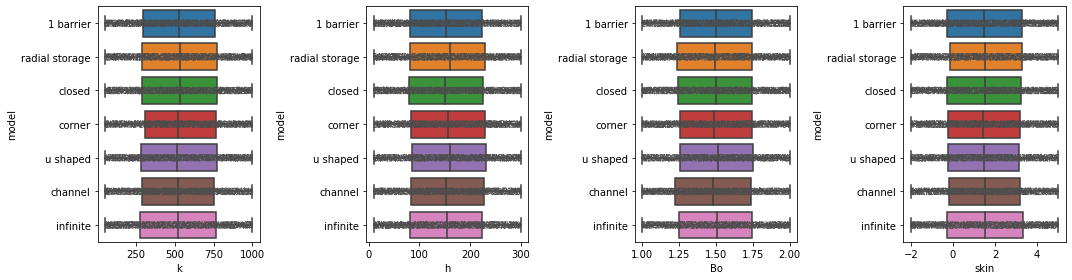

In [49]:
models = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed", "radial storage"]
fig, axes = plt.subplots(1, 4, figsize=(15,4), tight_layout=True)
for i,x in enumerate(["k", "h", "Bo", "skin"]):
    sns.boxplot(x=x, y="model", data=df, ax=axes[i])
    sns.stripplot(x=x, y="model", data=df, ax=axes[i],
              size=1, color=".3", linewidth=0)

#### Subset sample

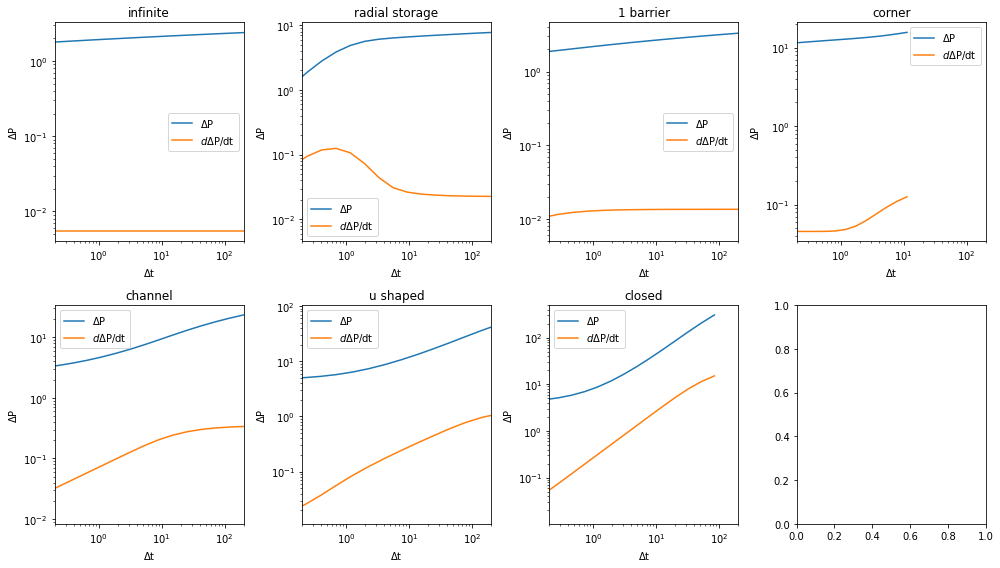

In [50]:
# Get random sample of each model
models = ["infinite", "radial storage", "1 barrier", "corner", "channel", "u shaped", "closed"]
data = []
for mod in models:
    data.append(df[df["model"] == mod].sample(random_state=11))

# Plot each model
fig, axs = plt.subplots(2,4,figsize=(14,8),tight_layout=True)
for i in range(2):
    for j in range(4):
        idx = i*4 + j
        if idx == 7:
            break
        tk = data[idx].values[0][15:35]
        dp_u = data[idx].values[0][35:55]
        der_u = data[idx].values[0][55:75]
        axs[i,j].loglog(tk, dp_u, label="$\Delta$P")
        axs[i,j].loglog(tk, der_u, label="$d\Delta$P/dt")
        axs[i,j].set_title(models[idx])
        axs[i,j].set_xlabel("$\Delta$t")
        axs[i,j].set_ylabel("$\Delta$P")
        axs[i,j].set_xlim(2e-1, 2e2)
        axs[i,j].legend()

### Training and testing datasets definition

In [51]:
# Get df values
X = df.values
X[X==0] = 1e-5
X_train_base, X_test_base = train_test_split(X, test_size=0.2, random_state=100, shuffle=True)

# Create and normalize train datasets
norm_log_p_train = normalize(np.log(X_train_base[:, 35:55].astype(float)))
norm_log_dp_train = normalize(np.log(X_train_base[:, 55:75].astype(float)))
# Discard time, normalize logP, logdP
X_train_1 = np.hstack([norm_log_p_train, norm_log_dp_train])

# Create and normalize test datasets
norm_log_p_test = normalize(np.log(X_test_base[:, 35:55].astype(float)))
norm_log_dp_test = normalize(np.log(X_test_base[:, 55:75].astype(float)))
# Discard time, normalize logP, logdP
X_test_1 = np.hstack([norm_log_p_test, norm_log_dp_test])

train_sets = [X_train_1]
test_sets  = [X_test_1]

print(f"Conjuntos de treino:")
for i, train_set in enumerate(train_sets):
    print(f"\t{i+1}. {train_set.shape}")
print(f"Conjuntos de teste:")
for i, test_set in enumerate(test_sets):
    print(f"\t{i+1}. {test_set.shape}")

Conjuntos de treino:
	1. (16000, 40)
Conjuntos de teste:
	1. (4000, 40)


### Autoencoders construction

In [52]:
models = []
for train_set in train_sets:
    # input layer
    input_layer = Input(shape=(train_set.shape[1],))

    # encoding architecture
    encode_layer1 = Dense(1024, activation='relu')(input_layer)
    encode_layer2 = Dense(512, activation='relu')(encode_layer1)
    encode_layer3 = Dense(256,  activation='relu')(encode_layer2)
    encode_layer4 = Dense(32,  activation='relu')(encode_layer3)

    # latent view
    latent_view   = Dense(8,  activation='linear', activity_regularizer=l1(10e-5))(encode_layer4)

    # decoding architecture
    decode_layer1 = Dense(32,  activation='relu')(latent_view)
    decode_layer2 = Dense(256, activation='relu')(decode_layer1)
    decode_layer3 = Dense(512, activation='relu')(decode_layer2)
    decode_layer4 = Dense(1024, activation='relu')(decode_layer3)

    # output layer
    output_layer  = Dense(train_set.shape[1], activation="linear")(decode_layer4)

    models.append(Model(input_layer, output_layer))

In [53]:
for i, (X_train, X_test) in enumerate(zip(train_sets, test_sets)):
    print(f"Started training model {i+1}")
    models[i].compile(optimizer='adam', # SGD
                      loss=tensorflow.keras.losses.mean_squared_error,
                      metrics=[tensorflow.keras.metrics.mean_squared_error])
    models[i].fit(X_train,
                  X_train,
                  epochs=100, # 200, 300, 1000
                  batch_size=32,
                  validation_data=(X_test, X_test))
    print(f"Finished training model {i+1}\n\n\n\n")

Started training model 1
Epoch 1/100
500/500 [==============================] - 6s 11ms/step - loss: 0.0022 - mean_squared_error: 0.0020 - val_loss: 2.0675e-04 - val_mean_squared_error: 1.1985e-04
Epoch 2/100
500/500 [==============================] - 6s 11ms/step - loss: 1.7974e-04 - mean_squared_error: 1.1767e-04 - val_loss: 1.4630e-04 - val_mean_squared_error: 1.0275e-04
Epoch 3/100
500/500 [==============================] - 5s 10ms/step - loss: 1.4412e-04 - mean_squared_error: 1.0757e-04 - val_loss: 2.4288e-04 - val_mean_squared_error: 2.1199e-04
Epoch 4/100
500/500 [==============================] - 5s 11ms/step - loss: 1.7368e-04 - mean_squared_error: 1.4710e-04 - val_loss: 3.1064e-04 - val_mean_squared_error: 2.7666e-04
Epoch 5/100
500/500 [==============================] - 5s 10ms/step - loss: 8.0427e-05 - mean_squared_error: 5.7168e-05 - val_loss: 1.2396e-04 - val_mean_squared_error: 1.0385e-04
Epoch 6/100
500/500 [==============================] - 5s 11ms/step - loss: 8.4221e

125/125 [==============================] - 1s 3ms/step


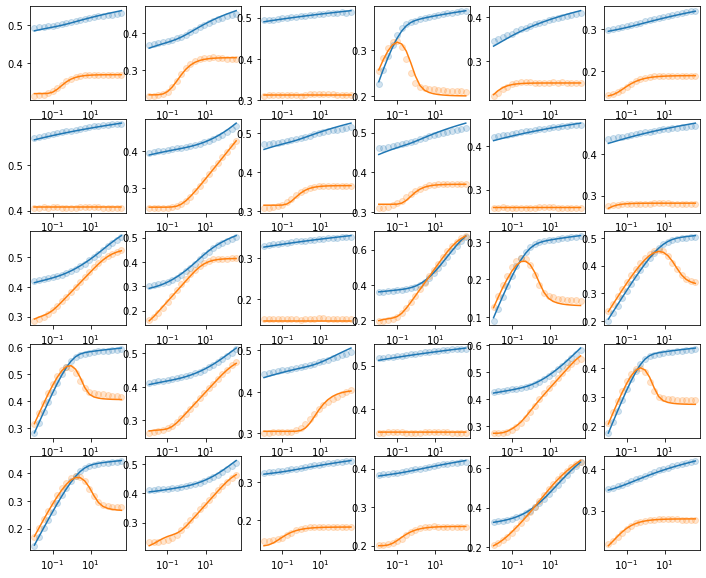

In [54]:
results = [model.predict(X_test) for (model, X_test) in zip(models, test_sets)]

fig, ax = plt.subplots(5,6,figsize=(12,10))
for i in range(5):
    for j in range(6):
        idx = i*6 + j
        tk = X_test_base[0][15:35]
        dp_u = test_sets[0][idx][0:20]
        der_u = test_sets[0][idx][20:40]
        result_dp_u = results[0][idx][0:20]
        result_der_u = results[0][idx][20:40]
        ax[i,j].plot(tk, dp_u)
        ax[i,j].plot(tk, der_u)
        ax[i,j].scatter(tk, result_dp_u, alpha=0.2)
        ax[i,j].scatter(tk, result_der_u, alpha=0.2)
        ax[i,j].semilogx()


### Minimum representation analysis

In [55]:
encoding_models = []
for model in models:
    layers = []
    new_model = Sequential()
    curr_layer = model.get_layer(index=0)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=1)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=2)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=3)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=4)
    new_model.add(curr_layer)
    curr_layer = model.get_layer(index=5)
    new_model.add(curr_layer)
    encoding_models.append(new_model)

125/125 [==============================] - 0s 2ms/step


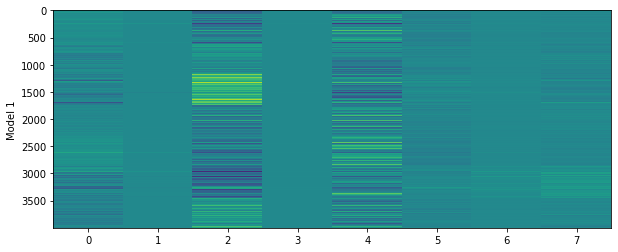

In [56]:
test_df = pd.DataFrame(X_test_base)
test_df = test_df.sort_values(0)
X_transmissibility = test_df.values[:, -1].astype(float)
X_transmissibility = 200*(X_transmissibility - np.min(X_transmissibility))/(np.max(X_transmissibility) - np.min(X_transmissibility))
X_duration = test_df.values[:, 34].astype(float)
X_duration = 200*normalize(X_duration)

# Create and normalize test datasets
norm_time_validate = normalize(test_df.values[:, 15:35].astype(float))
norm_log_p_validate = normalize(np.log(test_df.values[:, 35:55].astype(float)))
norm_log_dp_validate = normalize(np.log(test_df.values[:, 55:75].astype(float)))
# 1 Discard time, normalize logP, logdP
X_validate_1 = np.hstack([norm_log_p_validate, norm_log_dp_validate])

validation_sets = [X_validate_1]

data = [encoder.predict(X_validate) for (encoder, X_validate) in zip(encoding_models, validation_sets)]

fig, ax = plt.subplots(len(validation_sets),1,figsize=(10,4))
for i in range(len(validation_sets)):
    ax.set_ylabel(f"Model {i+1}")
    ax.imshow(data[i], interpolation="nearest", aspect="auto")

#### Bidimensional representation

The [T-SNE](https://lvdmaaten.github.io/tsne/) was used to reduce data dimmensionality

##### 2D representation

In [57]:
labels = test_df[0].values
embedding = [TSNE(n_components=2, random_state=1).fit(dt) for dt in data]

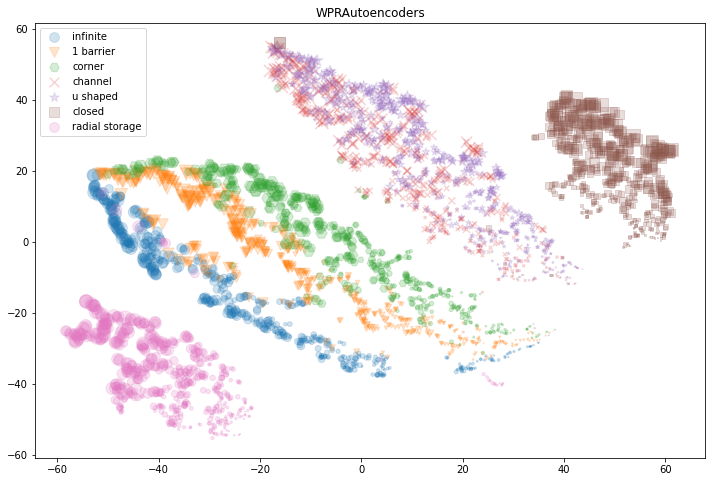

In [58]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
models = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed", "radial storage"]
markers = ["o", "v", "H", "x", "*", "s", "o"]
for k,mdl in enumerate(models):
    ax.scatter(embedding[0][np.where(labels == mdl), 0], 
               embedding[0][np.where(labels == mdl), 1], 
               marker=markers[k], 
               alpha=0.2, 
               s=X_transmissibility[np.where(labels == mdl)],
               label=mdl)
    ax.set_title(f"WPRAutoencoders")
    ax.legend()

##### 3D representation

In [59]:
labels = test_df[0].values
embedding = [TSNE(n_components=3, random_state=1).fit(dt) for dt in data]

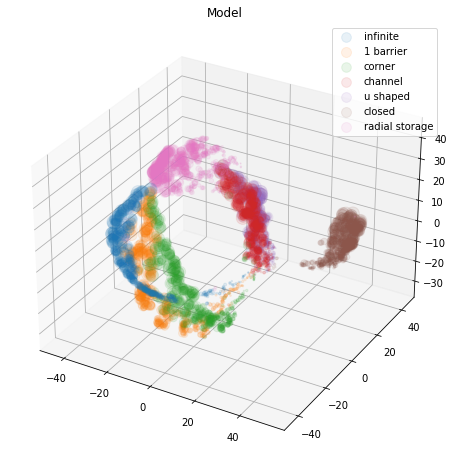

In [60]:
# %matplotlib widget
%matplotlib inline

labels = test_df[0].values

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
models = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed", "radial storage"]
# models = ["1 barrier", "corner"]
markers = ["o", "v", "H", "x", "*", "s", "o"]
for k,mdl in enumerate(models):
    ax.scatter3D(embedding[0][np.where(labels == mdl), 0], 
                 embedding[0][np.where(labels == mdl), 1],
                 embedding[0][np.where(labels == mdl), 2], 
                 s=X_transmissibility[np.where(labels == mdl)],
                 label=mdl,
                 alpha=0.1);
    ax.set_title(f"Model")
    ax.legend()

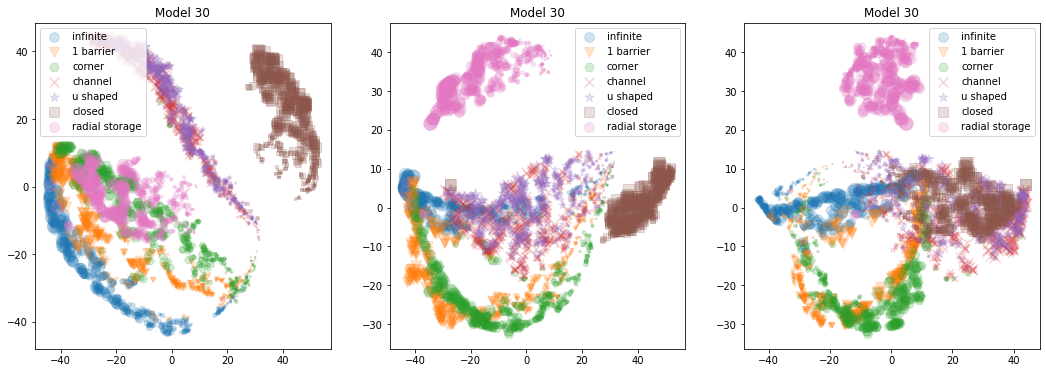

In [61]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
models = ["infinite", "1 barrier", "corner", "channel", "u shaped", "closed", "radial storage"]
# models = ["1 barrier", "corner"]
markers = ["o", "v", "H", "x", "*", "s", "o"]
opts = [(0,1), (0,2), (1,2)]
for i,j in opts:
    for k,mdl in enumerate(models):
        ax[i+j-1].scatter(embedding[0][np.where(labels == mdl), i], 
                          embedding[0][np.where(labels == mdl), j], 
                          marker=markers[k], 
                          alpha=0.2, 
                          s=X_transmissibility[np.where(labels == mdl)],
                          label=mdl)
        ax[i+j-1].set_title(f"Model {idx+1}")
        ax[i+j-1].legend()

#### Model storage

In [62]:
encoding_models[0].save("../models/trained_model.h5")